In [1]:
import matplotlib
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

def start_plot():
    mpl.rcParams['legend.fontsize'] = 10
    fig = plt.figure(figsize=(8, 8), dpi=100)
    ax = fig.gca()
    return ax, fig

def show_plot(ax=None, fig=None, plt_title='', x_label='x', y_label='y', lim=25):
    plt.title(plt_title, fontsize=14)
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    plt.show()
    fig.show()


def get_radius(w):
    return w.norm()

def get_loss(w):
    return w.norm() ** 2

def loss_gradient(w):
    return 2.0*w

def update(r, w, prev_delta_w, alpha=0, optim='gradient'):
    if optim == "gradient":
        delta_w = -r * loss_gradient(w)
        fmt = "bo"
    elif optim == "momentum":
        if prev_delta_w is None:
            delta_w = - r * loss_gradient(w)
        else:
            delta_w = alpha * prev_delta_w - r * loss_gradient(w)
        fmt = "go"
    elif optim == "nesterov":
        if prev_delta_w is None:
            delta_w = - r * loss_gradient(w)
        else:
            w_look_ahead = w + prev_delta_w
            delta_w = alpha * prev_delta_w - r * loss_gradient(w_look_ahead) 
    else:
        raise NotImplementedError 
    return delta_w

def colors(optim):
    if optim is "gradient":
        circle_color = "blue"
        arrow_color = "black"
        fmt = "bo"
    elif optim is "momentum":
        circle_color = "green"
        arrow_color = "black"
        fmt = "go"
    elif optim is "nesterov":
        circle_color = "green"
        arrow_color = "black"
        fmt = "go"

    else:
        raise NotImplementedError 
    return circle_color, arrow_color, fmt

def plot_one_iter(ax, center, w, delta_w, circle_color, arrow_color, fmt):
    """
    Plots 
        - a circle at w 
        - a point at w
        - a vector from prev_w to w
    """
    radius = get_radius(w)
    if radius == 0:
        return
    circle = plt.Circle(center, radius, color=circle_color, fill=False)
    ax.add_patch(circle)
    plt.plot(w[0], w[1], fmt) 
    if delta_w is not None:
        prev_w = w - delta_w
        plt.arrow(prev_w[0], prev_w[1], delta_w[0], delta_w[1], color=arrow_color, width=0.2, head_width=10, 
                  head_length=10, length_includes_head=True)

def plot_text(start_loss, end_loss, num_iters):
    plt.text(120, 230, "Start Loss: {:0.1f}".format(start_loss), fontsize=12)
    plt.text(120, 210, "End Loss: {:0.1f}".format(end_loss), fontsize=12)
    plt.text(120, 190, "Num Iters: {}".format(num_iters), fontsize=12)

        
def contours_and_trajectory(w, r=0.2, alpha=0.2, optim="gradient"):
    center = (0, 0)
    radius = get_radius(w)
    prev_radius = None
    ws = [w]
    delta_ws = []
    circle_color, arrow_color, fmt = colors(optim)
    overshot = False
    plt.plot(0, 0, marker='x', markersize=12, color="black")
    while True:
        w = ws[-1]
        delta_w = delta_ws[-1] if delta_ws else None
        prev_w = ws[-2] if len(ws) >= 2 else None
        prev_delta_w = delta_ws[-2] if len(delta_ws) >= 2 else None
        radius = get_radius(w)
        prev_radius = get_radius(prev_w) if prev_w is not None else None
        if prev_radius is not None and radius > prev_radius:
            arrow_color = "red"
            circle_color = "red"
            fmt = "ro"
            overshot = True
            plot_one_iter(ax, center, w, delta_w, circle_color, arrow_color, fmt)
            break
        plot_one_iter(ax, center, w, delta_w, circle_color, arrow_color, fmt)
        delta_w = update(r, w, prev_delta_w, alpha, optim)
        w = w + delta_w
        ws.append(w)
        delta_ws.append(delta_w)
        if get_loss(w) < 50:
            break
    start_loss = get_loss(ws[0])
    end_loss = get_loss(ws[-1])
    print("Iter\tRadius\tLoss")
    for i in range(len(ws)):
        print("{}\t{:0.2f}\t{:0.2f}".format(i, get_radius(ws[i]), get_loss(ws[i])))
    num_iters = len(ws) - 1
    return start_loss, end_loss, num_iters

Iter	Radius	Loss
0	223.61	50000.00
1	134.16	18000.00
2	80.50	6480.00
3	48.30	2332.80
4	28.98	839.81
5	17.39	302.33
6	10.43	108.84
7	6.26	39.18


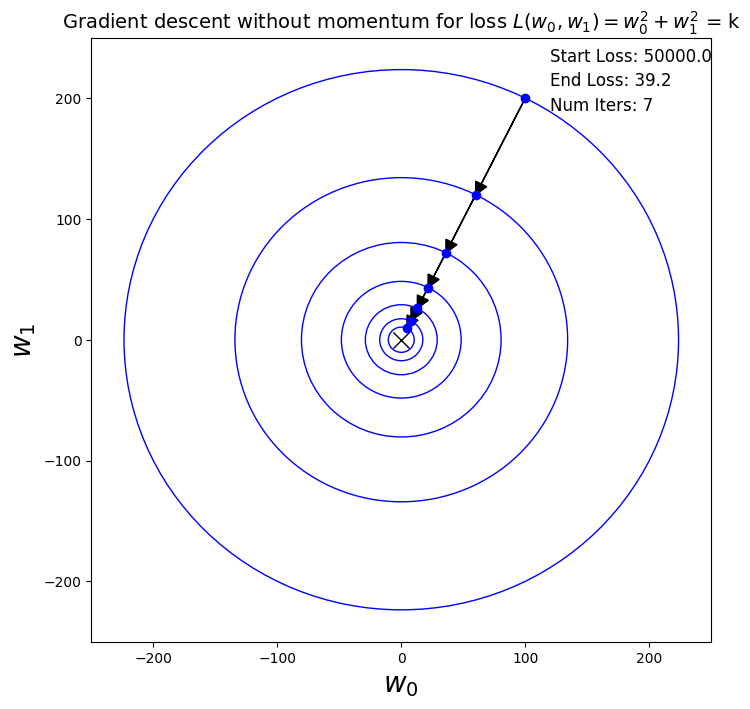

In [6]:
ax, fig = start_plot()
radius = 15
w = [100, 200]
lim = 1.25 * max(w)

start_loss, end_loss, num_iters = contours_and_trajectory(torch.tensor(w, dtype=torch.float32), optim="gradient")
plot_text(start_loss, end_loss, num_iters)
show_plot(ax, fig, plt_title=r"Gradient descent without momentum for loss $L(w_{0}, w_{1}) = w_{0}^{2} + w_{1}^{2}$ = k",
              x_label=r"$w_{0}$", y_label=r"$w_{1}$", lim=lim)

Iter	Radius	Loss
0	223.61	50000.00
1	134.16	18000.00
2	80.50	6480.00
3	30.41	924.80
4	7.51	56.45
5	5.51	30.36


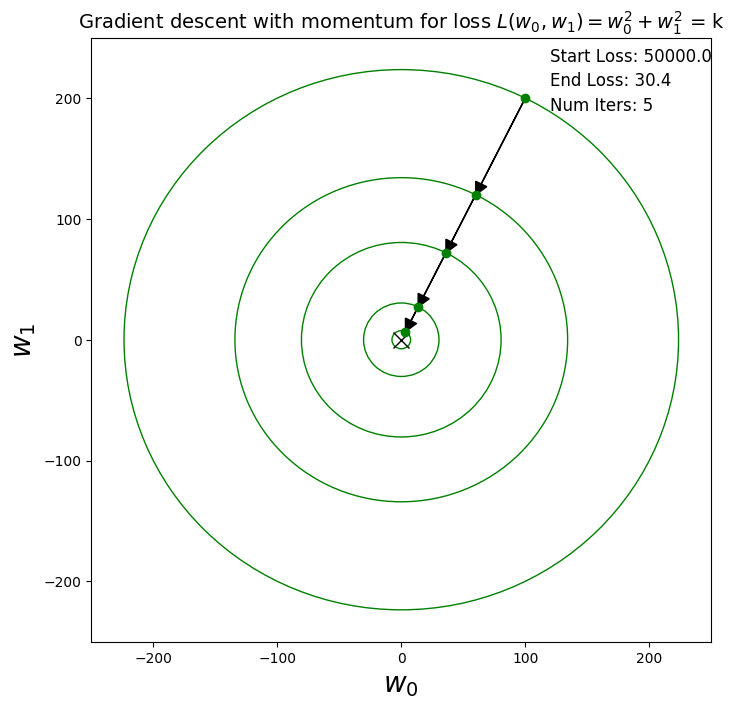

In [7]:
ax, fig = start_plot()
radius = 15
w = [100, 200]
lim = 1.25 * max(w)

start_loss, end_loss, num_iters = contours_and_trajectory(torch.tensor(w, dtype=torch.float32), optim="momentum")
plot_text(start_loss, end_loss, num_iters)

show_plot(ax, fig, plt_title=r"Gradient descent with momentum for loss $L(w_{0}, w_{1}) = w_{0}^{2} + w_{1}^{2}$ = k",
              x_label=r"$w_{0}$", y_label=r"$w_{1}$", lim=lim)

Iter	Radius	Loss
0	223.61	50000.00
1	89.44	8000.00
2	35.78	1280.00
3	52.77	2784.80


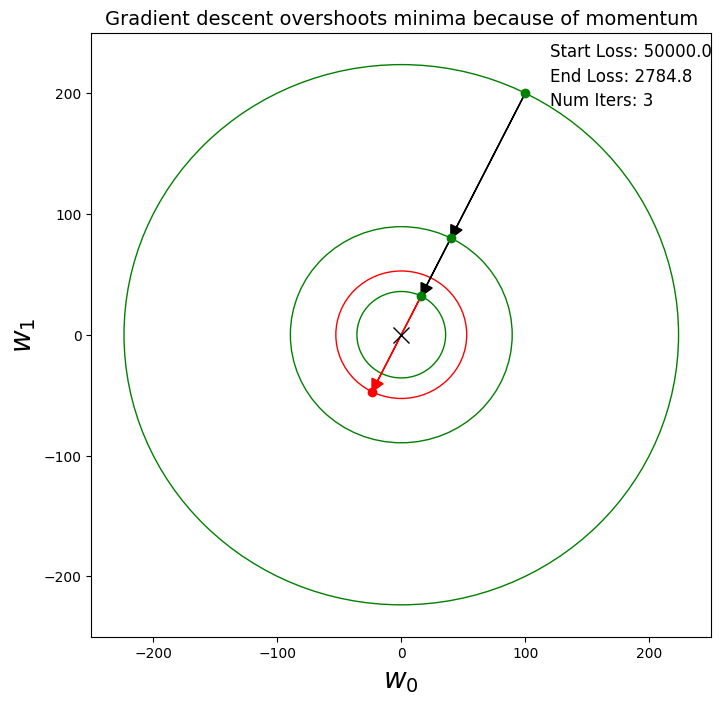

In [8]:
ax, fig = start_plot()
radius = 15
w = [100, 200]
lim = 1.25 * max(w)

start_loss, end_loss, num_iters = contours_and_trajectory(torch.tensor(w, dtype=torch.float32), r=0.3, alpha=0.5, optim="momentum")
plot_text(start_loss, end_loss, num_iters)
show_plot(ax, fig, plt_title=r"Gradient descent overshoots minima because of momentum",
              x_label=r"$w_{0}$", y_label=r"$w_{1}$", lim=lim)

Iter	Radius	Loss
0	223.61	50000.00
1	89.44	8000.00
2	35.78	1280.00
3	27.73	768.80
4	16.46	270.85
5	7.39	54.58
6	4.08	16.66


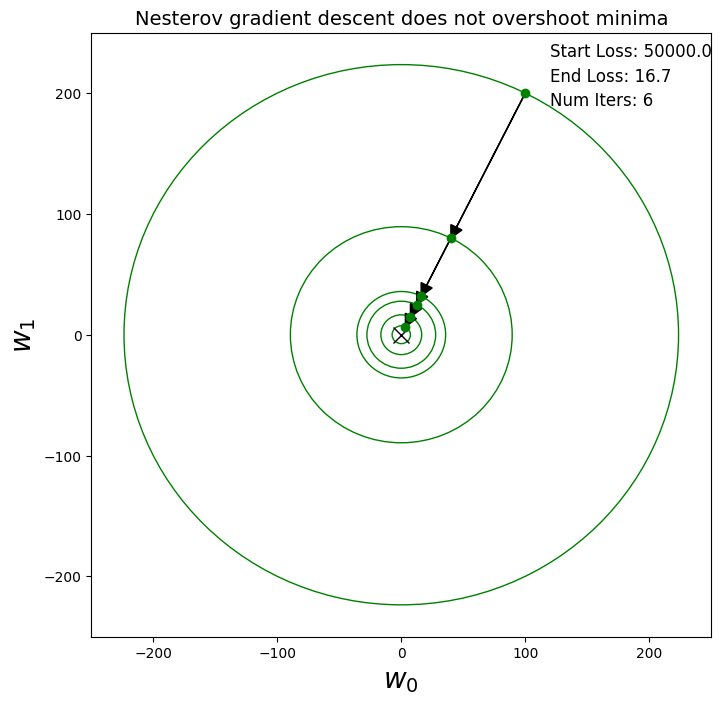

In [9]:
ax, fig = start_plot()
radius = 15
w = [100, 200]
lim = 1.25 * max(w)

start_loss, end_loss, num_iters = contours_and_trajectory(
    torch.tensor(w, dtype=torch.float32), r=0.3, alpha=0.5, optim="nesterov")
plot_text(start_loss, end_loss, num_iters)
show_plot(ax, fig, plt_title=r"Nesterov gradient descent does not overshoot minima",
              x_label=r"$w_{0}$", y_label=r"$w_{1}$", lim=lim)